In [33]:
import matplotlib.pyplot as plt
import matplotlib
import numpy 
import cv2
import os
import glob
import time
import numpy as np
import pandas as pd
from tqdm import tqdm
from keras.models import Model
from keras import optimizers
from keras.applications import *
from keras.models import Sequential
from keras.layers import Dense, Dropout, Flatten, Conv2D, BatchNormalization, MaxPooling2D
import keras.utils as np_utils
from sklearn import preprocessing
from sklearn.model_selection import train_test_split
%matplotlib inline

/usr/local/lib/python3.6/site-packages/h5py/__init__.py:36: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  from ._conv import register_converters as _register_converters
Using TensorFlow backend.


In [8]:
dpath = '/Users/nickfranciose/.kaggle/competitions/dog-breed-identification/'

In [9]:
os.listdir(dpath)

['labels.csv', '.DS_Store', 'test', 'train', 'sample_submission.csv']

In [10]:
files = sorted(glob.glob(dpath+'train/*.jpg'))

In [11]:
len(files)

10222

In [12]:
files[0]

'/Users/nickfranciose/.kaggle/competitions/dog-breed-identification/train/000bec180eb18c7604dcecc8fe0dba07.jpg'

In [14]:
labels = pd.read_csv('/Users/nickfranciose/.kaggle/competitions/dog-breed-identification/labels.csv')

In [15]:
labels.head()

,id,breed
0,000bec180eb18c7604dcecc8fe0dba07,boston_bull
1,001513dfcb2ffafc82cccf4d8bbaba97,dingo
2,001cdf01b096e06d78e9e5112d419397,pekinese
3,00214f311d5d2247d5dfe4fe24b2303d,bluetick
4,0021f9ceb3235effd7fcde7f7538ed62,golden_retriever


In [23]:
test = pd.read_csv(dpath+'sample_submission.csv')

In [29]:
test.id.values

array(['000621fb3cbb32d8935728e48679680e',
       '00102ee9d8eb90812350685311fe5890',
       '0012a730dfa437f5f3613fb75efcd4ce', ...,
       'fff74b59b758bbbf13a5793182a9bbe4',
       'fff7d50d848e8014ac1e9172dc6762a3',
       'fffbff22c1f51e3dc80c4bf04089545b'], dtype=object)

Translate labels to one hot dummies

In [16]:
targets_series = pd.Series(labels['breed'])
one_hot = pd.get_dummies(targets_series, sparse = True)
one_hot_labels = np.asarray(one_hot)

In [19]:
image_size = 150
x_train = []
y_train = []
x_test = []
y_test = []

In [22]:
i = 0 
for f, breed in tqdm(labels.values):
    img = cv2.imread(dpath+'train/{}.jpg'.format(f))
    label = one_hot_labels[i]
    x_train.append(cv2.resize(img, (image_size, image_size)))
    y_train.append(label)
    i += 1

100%|██████████| 10222/10222 [00:42<00:00, 241.92it/s]


In [30]:
for f in tqdm(test.id.values):
    img = cv2.imread(dpath+'test/{}.jpg'.format(f))
    x_test.append(cv2.resize(img, (image_size, image_size)))
    y_test.append(label)

100%|██████████| 10357/10357 [00:40<00:00, 254.81it/s]


In [50]:
y_train_init = np.array(y_train, np.uint8)
x_train_init = np.array(x_train, np.float32) / 255
x_test = np.array(x_test, np.float32) / 255
y_test = np.array(y_test, np.uint8)

In [51]:
num_targets = y_train_init.shape[1]

In [52]:
X_train, X_test, Y_train, Y_test = train_test_split(x_train_init, y_train_init, test_size=0.2, random_state=1)

In [54]:
def model():
    model = Sequential()
    model.add(Conv2D(16, (3, 3), input_shape=(150,150,3), activation='relu'))
    model.add(MaxPooling2D(pool_size=(2, 2)))
    model.add(Conv2D(32, (3, 3), activation='relu'))
    model.add(MaxPooling2D(pool_size=(2, 2)))
    model.add(Conv2D(64, (3, 3), activation='relu'))
    model.add(MaxPooling2D(pool_size=(2, 2)))
    model.add(Conv2D(128, (3, 3), activation='relu'))
    model.add(MaxPooling2D(pool_size=(2, 2)))
    model.add(Dropout(0.2))
    model.add(Flatten())
    model.add(Dense(512, activation='relu'))
    model.add(Dense(216, activation='relu'))
    model.add(Dense(128, activation='relu'))
    model.add(Dense(64, activation='relu'))
    model.add(Dense(num_targets, activation='softmax'))
    model.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['accuracy'])
    return model


model = model()


log = model.fit(x_train_init, y_train_init, validation_data=(X_test, Y_test), epochs=50, batch_size=200, verbose=1)
# Evaluate model
scores_test = model.evaluate(X_test, Y_test, verbose=0)
print("CNN Error: %.2f%%" % (100-scores[1]*100))
scores_train = model.evaluate(X_train, Y_train)
print("Test Score - {}".format(scores_test[0]))
print("Test Acc - {}".format(scores_test[1]))
print("Train Score - {}".format(scores_train[0]))
print("Train Acc - {}".format(scores_train[1]))

Train on 10222 samples, validate on 2045 samples
Epoch 1/50
10222/10222 [==============================] - 387s 38ms/step - loss: 4.7854 - acc: 0.0102 - val_loss: 4.7760 - val_acc: 0.0171
Epoch 2/50
10222/10222 [==============================] - 235s 23ms/step - loss: 4.7328 - acc: 0.0158 - val_loss: 4.6080 - val_acc: 0.0303
Epoch 3/50
10222/10222 [==============================] - 245s 24ms/step - loss: 4.5711 - acc: 0.0250 - val_loss: 4.6137 - val_acc: 0.0254
Epoch 4/50
10222/10222 [==============================] - 209s 20ms/step - loss: 4.4753 - acc: 0.0303 - val_loss: 4.3862 - val_acc: 0.0401
Epoch 5/50
10222/10222 [==============================] - 171s 17ms/step - loss: 4.3813 - acc: 0.0402 - val_loss: 4.3041 - val_acc: 0.0513
Epoch 6/50
10222/10222 [==============================] - 165s 16ms/step - loss: 4.3037 - acc: 0.0432 - val_loss: 4.2645 - val_acc: 0.0499
Epoch 7/50
10222/10222 [==============================] - 156s 15ms/step - loss: 4.2037 - acc: 0.0552 - val_loss: 4.0

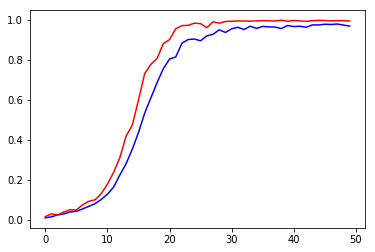

In [55]:
plt.plot(log.history['acc'],'b') 
plt.plot(log.history['val_acc'],'r')
plt.show()

In [99]:
def model_2(do=0.2):
    model = Sequential()
    model.add(Conv2D(16, (3, 3), input_shape=(150,150,3), activation='relu'))
    model.add(MaxPooling2D(pool_size=(2, 2)))
    model.add(Conv2D(32, (3, 3), activation='relu'))
    model.add(MaxPooling2D(pool_size=(2, 2)))
    model.add(Conv2D(64, (3, 3), activation='relu'))
    model.add(MaxPooling2D(pool_size=(2, 2)))
    model.add(Conv2D(128, (3, 3), activation='relu'))
    model.add(MaxPooling2D(pool_size=(2, 2)))
    model.add(Dropout(do))
    model.add(Flatten())
    model.add(Dense(512, activation='relu'))
    model.add(Dense(216, activation='relu'))
    model.add(Dense(128, activation='relu'))
    model.add(Dense(64, activation='relu'))
    model.add(Dense(num_targets, activation='softmax'))
    model.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['accuracy'])
    return model


Train on 10222 samples, validate on 2045 samples
Epoch 1/50
10222/10222 [==============================] - 256s 25ms/step - loss: 4.7875 - acc: 0.0106 - val_loss: 4.7819 - val_acc: 0.0137
Epoch 2/50
10222/10222 [==============================] - 195s 19ms/step - loss: 4.7763 - acc: 0.0102 - val_loss: 4.7554 - val_acc: 0.0142
Epoch 3/50
10222/10222 [==============================] - 177s 17ms/step - loss: 4.6982 - acc: 0.0163 - val_loss: 4.5740 - val_acc: 0.0225
Epoch 4/50
10222/10222 [==============================] - 193s 19ms/step - loss: 4.5224 - acc: 0.0273 - val_loss: 4.4524 - val_acc: 0.0230
Epoch 5/50
10222/10222 [==============================] - 206s 20ms/step - loss: 4.3876 - acc: 0.0349 - val_loss: 4.3257 - val_acc: 0.0513
Epoch 6/50
10222/10222 [==============================] - 181s 18ms/step - loss: 4.2829 - acc: 0.0488 - val_loss: 4.2120 - val_acc: 0.0582
Epoch 7/50
10222/10222 [==============================] - 204s 20ms/step - loss: 4.2043 - acc: 0.0518 - val_loss: 4.1

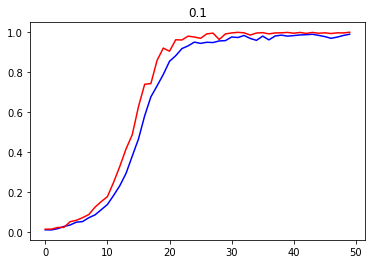

Train on 10222 samples, validate on 2045 samples
Epoch 1/50
10222/10222 [==============================] - 283s 28ms/step - loss: 4.7869 - acc: 0.0082 - val_loss: 4.7833 - val_acc: 0.0073
Epoch 2/50
10222/10222 [==============================] - 165s 16ms/step - loss: 4.7765 - acc: 0.0104 - val_loss: 4.7443 - val_acc: 0.0176
Epoch 3/50
10222/10222 [==============================] - 164s 16ms/step - loss: 4.6749 - acc: 0.0206 - val_loss: 4.5370 - val_acc: 0.0254
Epoch 4/50
10222/10222 [==============================] - 150s 15ms/step - loss: 4.4747 - acc: 0.0309 - val_loss: 4.3120 - val_acc: 0.0430
Epoch 5/50
10222/10222 [==============================] - 171s 17ms/step - loss: 4.3328 - acc: 0.0377 - val_loss: 4.2477 - val_acc: 0.0450
Epoch 6/50
10222/10222 [==============================] - 159s 16ms/step - loss: 4.2350 - acc: 0.0477 - val_loss: 4.1344 - val_acc: 0.0592
Epoch 7/50
10222/10222 [==============================] - 156s 15ms/step - loss: 4.1435 - acc: 0.0608 - val_loss: 3.9

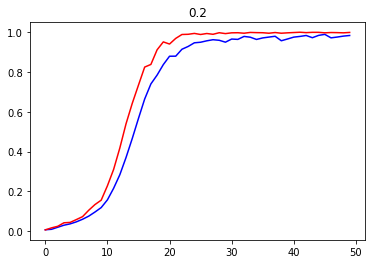

Train on 10222 samples, validate on 2045 samples
Epoch 1/50
10222/10222 [==============================] - 251s 25ms/step - loss: 4.7869 - acc: 0.0092 - val_loss: 4.7797 - val_acc: 0.0112
Epoch 2/50
10222/10222 [==============================] - 173s 17ms/step - loss: 4.7686 - acc: 0.0138 - val_loss: 4.7244 - val_acc: 0.0191
Epoch 3/50
10222/10222 [==============================] - 162s 16ms/step - loss: 4.6427 - acc: 0.0205 - val_loss: 4.5471 - val_acc: 0.0274
Epoch 4/50
10222/10222 [==============================] - 162s 16ms/step - loss: 4.5042 - acc: 0.0295 - val_loss: 4.4273 - val_acc: 0.0337
Epoch 5/50
10222/10222 [==============================] - 156s 15ms/step - loss: 4.4083 - acc: 0.0352 - val_loss: 4.2976 - val_acc: 0.0499
Epoch 6/50
10222/10222 [==============================] - 167s 16ms/step - loss: 4.3153 - acc: 0.0441 - val_loss: 4.1983 - val_acc: 0.0548
Epoch 7/50
10222/10222 [==============================] - 154s 15ms/step - loss: 4.2287 - acc: 0.0528 - val_loss: 4.2

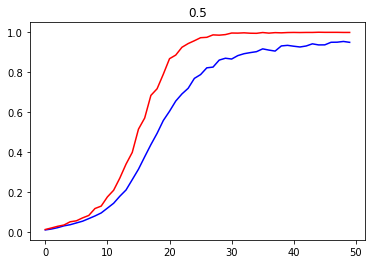

In [103]:
for do in [0.1, 0.2, 0.5]:
    def model_2(do=0.2):
        model = Sequential()
        model.add(Conv2D(16, (3, 3), input_shape=(150,150,3), activation='relu'))
        model.add(MaxPooling2D(pool_size=(2, 2)))
        model.add(Conv2D(32, (3, 3), activation='relu'))
        model.add(MaxPooling2D(pool_size=(2, 2)))
        model.add(Conv2D(64, (3, 3), activation='relu'))
        model.add(MaxPooling2D(pool_size=(2, 2)))
        model.add(Conv2D(128, (3, 3), activation='relu'))
        model.add(MaxPooling2D(pool_size=(2, 2)))
        model.add(Dropout(do))
        model.add(Flatten())
        model.add(Dense(512, activation='relu'))
        model.add(Dense(216, activation='relu'))
        model.add(Dense(128, activation='relu'))
        model.add(Dense(64, activation='relu'))
        model.add(Dense(num_targets, activation='softmax'))
        model.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['accuracy'])
        return model
    
    # build the model
    #model = model_overfit3(0.001,do)
    model_2 = model_2(do)
    
    # Fit the model
    t0=time.time()
    log_2 = model_2.fit(x_train_init, y_train_init, validation_data=(X_test, Y_test), epochs=50, batch_size=200, verbose=1)
    t1=time.time()
    print('DO=',do, t1-t0," seconds")

    scores_test = model_2.evaluate(X_test, Y_test, verbose=0)
    print("CNN Error: %.2f%%" % (100-scores[1]*100))
    scores_train = model_2.evaluate(X_train, Y_train)
    print("Test Score - {}".format(scores_test[0]))
    print("Test Acc - {}".format(scores_test[1]))
    print("Train Score - {}".format(scores_train[0]))
    print("Train Acc - {}".format(scores_train[1]))

    plt.plot(log_2.history['acc'],'b') 
    plt.plot(log_2.history['val_acc'],'r')
    #plt.title(do)
    plt.title(str(do))
    plt.show()

In [39]:
predictions = model.predict(x_test, verbose=1)

10357/10357 [==============================] - 133s 13ms/step


In [40]:
submission = pd.DataFrame(predictions)
factors = one_hot.columns.values
submission.columns = factors
submission.insert(0, 'id', test.id)
submission.head()

,id,affenpinscher,afghan_hound,african_hunting_dog,airedale,american_staffordshire_terrier,appenzeller,australian_terrier,basenji,basset,...,toy_poodle,toy_terrier,vizsla,walker_hound,weimaraner,welsh_springer_spaniel,west_highland_white_terrier,whippet,wire-haired_fox_terrier,yorkshire_terrier
0,000621fb3cbb32d8935728e48679680e,6.314089e-14,6.091849e-05,1.073542e-21,7.569749e-12,3.300079e-06,1.561356e-22,1.834404e-12,7.086417e-14,1.551044e-15,...,2.015860e-11,2.078219e-09,1.983452e-23,1.457021e-15,1.463845e-05,5.279421e-11,3.445558e-06,2.203828e-14,1.479182e-07,1.170489e-07
1,00102ee9d8eb90812350685311fe5890,1.419868e-10,1.956108e-13,6.231487e-19,2.139090e-22,5.269229e-09,2.464633e-15,8.442312e-21,5.638141e-21,1.371032e-22,...,2.449438e-07,1.820312e-13,1.521888e-32,7.088916e-08,6.791553e-09,9.116776e-18,1.310125e-05,8.732234e-11,7.841348e-05,1.793727e-12
2,0012a730dfa437f5f3613fb75efcd4ce,1.794253e-11,8.881756e-12,5.555783e-08,2.270402e-07,1.048328e-12,3.918504e-17,3.903701e-11,5.512315e-16,2.756379e-18,...,2.235792e-08,3.774603e-17,2.546398e-17,1.380209e-11,2.401850e-08,8.233553e-10,2.535260e-10,1.832025e-07,1.053054e-07,1.871720e-11
3,001510bc8570bbeee98c8d80c8a95ec1,6.678068e-16,1.177632e-13,9.885166e-08,4.074293e-09,7.004884e-09,3.551726e-19,9.539005e-11,4.203429e-15,5.815424e-12,...,5.364946e-12,4.111156e-12,1.373751e-12,7.220348e-18,2.697777e-03,3.237800e-17,8.721743e-13,2.165752e-17,3.225670e-13,6.225414e-07
4,001a5f3114548acdefa3d4da05474c2e,8.650192e-11,1.437429e-07,2.645192e-12,5.495542e-12,1.701416e-02,5.393146e-08,8.384300e-13,2.854670e-07,6.335173e-07,...,6.374305e-09,1.189471e-04,2.595294e-14,3.443415e-07,5.789548e-07,9.194810e-06,4.212980e-04,4.241116e-07,1.049902e-07,6.735764e-10


In [41]:
submission.to_csv('dog_breed_classification.csv',index = False)